In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras 

from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

## 1. READING DATA

In [178]:
data = pd.read_csv('data/IPL Matches 2008-2020.csv')
data.sample(5)

,id,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2
678,1136603,Jaipur,2018-05-11,JC Buttler,Sawai Mansingh Stadium,0,Rajasthan Royals,Chennai Super Kings,Chennai Super Kings,bat,Rajasthan Royals,wickets,4.0,N,NaN,M Erasmus,YC Barde
519,980905,Chandigarh,2016-04-11,AJ Finch,"Punjab Cricket Association IS Bindra Stadium, ...",0,Kings XI Punjab,Gujarat Lions,Gujarat Lions,field,Gujarat Lions,wickets,5.0,N,NaN,AK Chaudhary,VA Kulkarni
698,1175358,Mumbai,2019-03-24,RR Pant,Wankhede Stadium,0,Mumbai Indians,Delhi Capitals,Mumbai Indians,field,Delhi Capitals,runs,37.0,N,NaN,YC Barde,S Ravi
22,336004,Mumbai,2008-05-04,SM Pollock,Dr DY Patil Sports Academy,0,Mumbai Indians,Delhi Daredevils,Delhi Daredevils,field,Mumbai Indians,runs,29.0,N,NaN,IL Howell,RE Koertzen
186,501209,Jaipur,2011-04-15,G Gambhir,Sawai Mansingh Stadium,0,Rajasthan Royals,Kolkata Knight Riders,Kolkata Knight Riders,field,Kolkata Knight Riders,wickets,9.0,N,NaN,Aleem Dar,SS Hazare


## 2. GETTING TO KNOW DATA

In [179]:
data.shape
#816 rows and 17 columns

(816, 17)

In [180]:
data.info()
# getting information about all data columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               816 non-null    int64  
 1   city             803 non-null    object 
 2   date             816 non-null    object 
 3   player_of_match  812 non-null    object 
 4   venue            816 non-null    object 
 5   neutral_venue    816 non-null    int64  
 6   team1            816 non-null    object 
 7   team2            816 non-null    object 
 8   toss_winner      816 non-null    object 
 9   toss_decision    816 non-null    object 
 10  winner           812 non-null    object 
 11  result           812 non-null    object 
 12  result_margin    799 non-null    float64
 13  eliminator       812 non-null    object 
 14  method           19 non-null     object 
 15  umpire1          816 non-null    object 
 16  umpire2          816 non-null    object 
dtypes: float64(1), i

In [181]:
data.dropna(subset=['winner'],inplace=True) 
#removing null 'winner' rows because winner is prediction column

In [182]:
data.shape # 4 data rows are removed on removing null values from winner 

(812, 17)

In [183]:
data.drop(['method','id'],axis=1,inplace=True) 
#removing id - not necessary
#removing method - almost all NAN values

In [184]:
data.shape # 2 columns are removed above

(812, 15)

In [185]:
data.sample(5)

,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,umpire1,umpire2
70,Cape Town,2009-04-26,KC Sangakkara,Newlands,1,Kings XI Punjab,Rajasthan Royals,Kings XI Punjab,bat,Kings XI Punjab,runs,27.0,N,M Erasmus,K Hariharan
120,Ahmedabad,2010-03-15,V Sehwag,"Sardar Patel Stadium, Motera",0,Rajasthan Royals,Delhi Daredevils,Delhi Daredevils,field,Delhi Daredevils,wickets,6.0,N,BG Jerling,RE Koertzen
84,East London,2009-05-04,MS Dhoni,Buffalo Park,1,Chennai Super Kings,Deccan Chargers,Chennai Super Kings,bat,Chennai Super Kings,runs,78.0,N,BR Doctrove,M Erasmus
80,Port Elizabeth,2009-05-02,YK Pathan,St George's Park,1,Deccan Chargers,Rajasthan Royals,Deccan Chargers,bat,Rajasthan Royals,wickets,3.0,N,S Asnani,BG Jerling
577,Hyderabad,2017-04-05,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",0,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,Sunrisers Hyderabad,runs,35.0,N,AY Dandekar,NJ Llong


In [186]:
data.columns

Index(['city', 'date', 'player_of_match', 'venue', 'neutral_venue', 'team1',
       'team2', 'toss_winner', 'toss_decision', 'winner', 'result',
       'result_margin', 'eliminator', 'umpire1', 'umpire2'],
      dtype='object')

## 3. Handling Missing values

C:\Users\91700\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


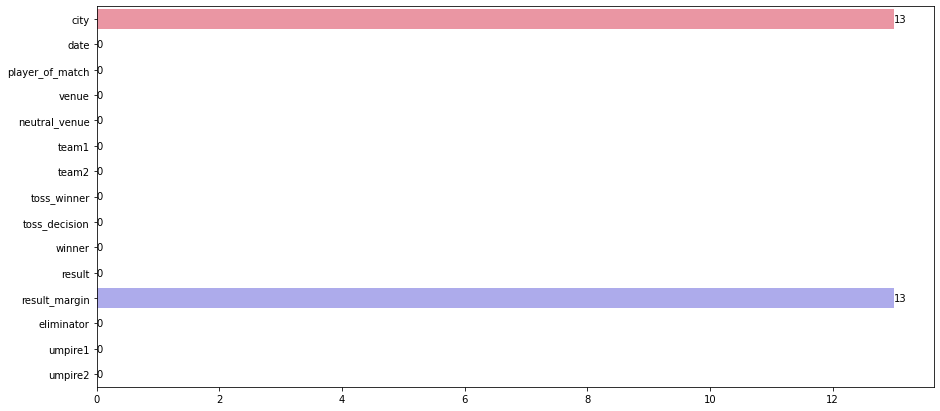

In [187]:
plt.figure(figsize=(15,7)) #plotting a bar plot to visualize number of missing values
ax = sns.barplot(data.isna().sum(),data.columns)
ax.bar_label(ax.containers[0]);

## 4. Simple Imputation

* result_margin - mean values
* city - most frequent

In [188]:
imputer1 = SimpleImputer(strategy='mean')
imputer2 = SimpleImputer(strategy='most_frequent')
trans = ColumnTransformer([
    ('impute1',imputer1,['result_margin']),
    ('impute2',imputer2,['city'])
], remainder='passthrough')

In [189]:
data = trans.fit_transform(data)

In [190]:
data[0]

array([140.0, 'Bangalore', '2008-04-18', 'BB McCullum',
       'M Chinnaswamy Stadium', 0, 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Royal Challengers Bangalore', 'field',
       'Kolkata Knight Riders', 'runs', 'N', 'Asad Rauf', 'RE Koertzen'],
      dtype=object)

In [191]:
data = pd.DataFrame(data,columns= ['result_margin','city', 'date', 'player_of_match', 'venue', 'neutral_venue', 'team1',
       'team2', 'toss_winner', 'toss_decision', 'winner', 'result', 'eliminator', 'umpire1', 'umpire2'])

In [192]:
data.head()

,result_margin,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,eliminator,umpire1,umpire2
0,140.0,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,N,Asad Rauf,RE Koertzen
1,33.0,Chandigarh,2008-04-19,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,N,MR Benson,SL Shastri
2,9.0,Delhi,2008-04-19,MF Maharoof,Feroz Shah Kotla,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,N,Aleem Dar,GA Pratapkumar
3,5.0,Mumbai,2008-04-20,MV Boucher,Wankhede Stadium,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,N,SJ Davis,DJ Harper
4,5.0,Kolkata,2008-04-20,DJ Hussey,Eden Gardens,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,N,BF Bowden,K Hariharan


In [193]:
data.isna().sum()

result_margin      0
city               0
date               0
player_of_match    0
venue              0
neutral_venue      0
team1              0
team2              0
toss_winner        0
toss_decision      0
winner             0
result             0
eliminator         0
umpire1            0
umpire2            0
dtype: int64

In [194]:
data.drop('player_of_match',axis=1,inplace=True)

In [195]:
data.head()

,result_margin,city,date,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,eliminator,umpire1,umpire2
0,140.0,Bangalore,2008-04-18,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,N,Asad Rauf,RE Koertzen
1,33.0,Chandigarh,2008-04-19,"Punjab Cricket Association Stadium, Mohali",0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,N,MR Benson,SL Shastri
2,9.0,Delhi,2008-04-19,Feroz Shah Kotla,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,N,Aleem Dar,GA Pratapkumar
3,5.0,Mumbai,2008-04-20,Wankhede Stadium,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,N,SJ Davis,DJ Harper
4,5.0,Kolkata,2008-04-20,Eden Gardens,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,N,BF Bowden,K Hariharan


In [196]:
for i in range(data.shape[0]):
    if data['toss_decision'][i]=='field':
        data['toss_decision'][i]=0
    else:
        data['toss_decision'][i]=1

In [197]:
for i in range(data.shape[0]):
    if data['result'][i]=='runs':
        data['result'][i]=0
    else:
        data['result'][i]=1

In [198]:
for i in range(data.shape[0]):
    if data['eliminator'][i]=='N':
        data['eliminator'][i]=0
    else:
        data['eliminator'][i]=1

In [199]:
np.unique(data['team1'])

array(['Chennai Super Kings', 'Deccan Chargers', 'Delhi Capitals',
       'Delhi Daredevils', 'Gujarat Lions', 'Kings XI Punjab',
       'Kochi Tuskers Kerala', 'Kolkata Knight Riders', 'Mumbai Indians',
       'Pune Warriors', 'Rajasthan Royals', 'Rising Pune Supergiant',
       'Rising Pune Supergiants', 'Royal Challengers Bangalore',
       'Sunrisers Hyderabad'], dtype=object)

In [200]:
teams = {'Chennai Super Kings':0,
         'Deccan Chargers':1,
         'Delhi Capitals':2,
         'Delhi Daredevils':2,
         'Gujarat Lions':3,
         'Kings XI Punjab':4,
         'Kochi Tuskers Kerala':5,
         'Kolkata Knight Riders':6,
         'Mumbai Indians':7,
         'Pune Warriors':8,
         'Rajasthan Royals':9,
         'Rising Pune Supergiant':8,
         'Rising Pune Supergiants':8,
         'Royal Challengers Bangalore':10,
         'Sunrisers Hyderabad':1}

In [201]:
data['teamA']=0
data['teamB']=0
data['winning_team']=0
data['winner_toss']=0

In [202]:
data.head()

,result_margin,city,date,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,eliminator,umpire1,umpire2,teamA,teamB,winning_team,winner_toss
0,140.0,Bangalore,2008-04-18,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,0,Kolkata Knight Riders,0,0,Asad Rauf,RE Koertzen,0,0,0,0
1,33.0,Chandigarh,2008-04-19,"Punjab Cricket Association Stadium, Mohali",0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,1,Chennai Super Kings,0,0,MR Benson,SL Shastri,0,0,0,0
2,9.0,Delhi,2008-04-19,Feroz Shah Kotla,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,1,Delhi Daredevils,1,0,Aleem Dar,GA Pratapkumar,0,0,0,0
3,5.0,Mumbai,2008-04-20,Wankhede Stadium,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,1,Royal Challengers Bangalore,1,0,SJ Davis,DJ Harper,0,0,0,0
4,5.0,Kolkata,2008-04-20,Eden Gardens,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,1,Kolkata Knight Riders,1,0,BF Bowden,K Hariharan,0,0,0,0


In [203]:
for i in range(data.shape[0]):
    data['teamA'][i]= teams[data['team1'][i]]
    data['teamB'][i]= teams[data['team2'][i]]
    data['winning_team'][i]= teams[data['winner'][i]]
    data['winner_toss'][i]= teams[data['toss_winner'][i]]

C:\Users\91700\AppData\Local\Temp/ipykernel_10496/387862497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['teamA'][i]= teams[data['team1'][i]]
C:\Users\91700\AppData\Local\Temp/ipykernel_10496/387862497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['teamB'][i]= teams[data['team2'][i]]
C:\Users\91700\AppData\Local\Temp/ipykernel_10496/387862497.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['winning_team'

In [204]:
stadiums = []
cities = []
for i in range(data.shape[0]):
    if data['neutral_venue'][i]==1:
        stadiums.append(data['venue'][i])
        cities.append(data['city'][i])

In [205]:
stadiums = np.unique(stadiums)

In [206]:
cities = np.unique(cities)

In [207]:
stadiums

array(['Buffalo Park', 'De Beers Diamond Oval',
       'Dubai International Cricket Stadium', 'Kingsmead',
       'New Wanderers Stadium', 'Newlands', 'OUTsurance Oval',
       'Sharjah Cricket Stadium', 'Sheikh Zayed Stadium',
       "St George's Park", 'SuperSport Park'], dtype='<U35')

In [208]:
cities = list(cities)
cities.remove('Mumbai')
cities = np.array(cities)

In [209]:
for i in range(data.shape[0]):
    if data['city'][i] in cities:
        data['city'][i] = 0
    else:
        data['city'][i] = 1 

C:\Users\91700\AppData\Local\Temp/ipykernel_10496/3069428240.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['city'][i] = 1
C:\Users\91700\AppData\Local\Temp/ipykernel_10496/3069428240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['city'][i] = 0


In [210]:
for i in range(data.shape[0]):
    if data['venue'][i] in stadiums:
        data['venue'][i] = 0
    else:
        data['venue'][i] = 1 

C:\Users\91700\AppData\Local\Temp/ipykernel_10496/3130100737.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['venue'][i] = 1
C:\Users\91700\AppData\Local\Temp/ipykernel_10496/3130100737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['venue'][i] = 0


In [211]:
data.head()

,result_margin,city,date,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,eliminator,umpire1,umpire2,teamA,teamB,winning_team,winner_toss
0,140.0,1,2008-04-18,1,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,0,Kolkata Knight Riders,0,0,Asad Rauf,RE Koertzen,10,6,6,10
1,33.0,1,2008-04-19,1,0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,1,Chennai Super Kings,0,0,MR Benson,SL Shastri,4,0,0,0
2,9.0,1,2008-04-19,1,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,1,Delhi Daredevils,1,0,Aleem Dar,GA Pratapkumar,2,9,2,9
3,5.0,1,2008-04-20,1,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,1,Royal Challengers Bangalore,1,0,SJ Davis,DJ Harper,7,10,10,7
4,5.0,1,2008-04-20,1,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,1,Kolkata Knight Riders,1,0,BF Bowden,K Hariharan,6,1,6,1


In [212]:
data['year']=2000

In [213]:
data.head()

,result_margin,city,date,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,eliminator,umpire1,umpire2,teamA,teamB,winning_team,winner_toss,year
0,140.0,1,2008-04-18,1,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,0,Kolkata Knight Riders,0,0,Asad Rauf,RE Koertzen,10,6,6,10,2000
1,33.0,1,2008-04-19,1,0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,1,Chennai Super Kings,0,0,MR Benson,SL Shastri,4,0,0,0,2000
2,9.0,1,2008-04-19,1,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,1,Delhi Daredevils,1,0,Aleem Dar,GA Pratapkumar,2,9,2,9,2000
3,5.0,1,2008-04-20,1,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,1,Royal Challengers Bangalore,1,0,SJ Davis,DJ Harper,7,10,10,7,2000
4,5.0,1,2008-04-20,1,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,1,Kolkata Knight Riders,1,0,BF Bowden,K Hariharan,6,1,6,1,2000


In [214]:
weekdays = [5,6]

In [215]:
for i in range(data.shape[0]):
    text = data['date'][i]
    dte = datetime.strptime(text,'%Y-%m-%d')
    data['year'][i] = 2020-dte.year

C:\Users\91700\AppData\Local\Temp/ipykernel_10496/2323042353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'][i] = 2020-dte.year


In [216]:
data.sample(5)

,result_margin,city,date,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,eliminator,umpire1,umpire2,teamA,teamB,winning_team,winner_toss,year
680,10.0,1,2018-05-14,1,0,Kings XI Punjab,Royal Challengers Bangalore,Royal Challengers Bangalore,0,Royal Challengers Bangalore,1,0,BNJ Oxenford,VK Sharma,4,10,10,10,2
505,5.0,1,2015-05-14,1,0,Mumbai Indians,Kolkata Knight Riders,Kolkata Knight Riders,0,Mumbai Indians,0,0,RK Illingworth,VA Kulkarni,7,6,7,6,5
237,11.0,1,2011-05-18,1,0,Chennai Super Kings,Kochi Tuskers Kerala,Chennai Super Kings,1,Chennai Super Kings,0,0,HDPK Dharmasena,RE Koertzen,0,5,0,0,9
776,7.0,1,2020-10-02,0,0,Sunrisers Hyderabad,Chennai Super Kings,Sunrisers Hyderabad,1,Sunrisers Hyderabad,0,0,AK Chaudhary,PR Reiffel,1,0,1,1,0
599,26.0,1,2017-04-23,1,0,Gujarat Lions,Kings XI Punjab,Gujarat Lions,0,Kings XI Punjab,0,0,AK Chaudhary,M Erasmus,3,4,4,3,3


In [217]:
data.drop(['date','team1','team2','toss_winner','winner','umpire1','umpire2'],axis=1,inplace=True)

In [218]:
data.head()

,result_margin,city,venue,neutral_venue,toss_decision,result,eliminator,teamA,teamB,winning_team,winner_toss,year
0,140.0,1,1,0,0,0,0,10,6,6,10,12
1,33.0,1,1,0,1,0,0,4,0,0,0,12
2,9.0,1,1,0,1,1,0,2,9,2,9,12
3,5.0,1,1,0,1,1,0,7,10,10,7,12
4,5.0,1,1,0,1,1,0,6,1,6,1,12


In [ ]:
print(np.mean(data['result_margin']))

In [219]:
X = data.drop('winning_team',axis=1)
y = data['winning_team']

In [220]:
Xfull = X.copy()

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [222]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
Xfull = scaler.fit_transform(Xfull)

In [223]:
X_train

array([[ 2.95790499,  0.34211049,  0.44680008, ...,  1.50697409,
         1.48605747, -0.83431388],
       [-0.56021381,  0.34211049,  0.44680008, ...,  1.20446058,
         0.59166678, -0.01720667],
       [-0.56021381,  0.34211049,  0.44680008, ...,  0.29692004,
         0.29353654, -0.56194481],
       ...,
       [ 0.81048183,  0.34211049,  0.44680008, ..., -1.21564752,
        -1.19711461, -0.28957574],
       [-0.51452395,  0.34211049,  0.44680008, ...,  1.50697409,
         0.59166678, -0.56194481],
       [-0.51452395,  0.34211049,  0.44680008, ..., -1.51816103,
        -1.49524484,  1.0722696 ]])

In [224]:
tree = DecisionTreeClassifier()
mnb = GaussianNB()
rf = RandomForestClassifier()
svm = SVC()

In [225]:
model_list = [tree,mnb,rf,svm]

In [226]:
def evaluate(model,X,y):
    cv_score = cross_val_score(model,X,y,scoring='accuracy',cv=10)
    score = np.round((np.mean(cv_score)*100),2)
    return score

In [227]:
score_list = []

In [228]:
for model in model_list:
    score = evaluate(model,Xfull,y)
    score_list.append(score)

C:\Users\91700\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\91700\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\91700\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\91700\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


In [229]:
score_list

[47.05, 6.77, 65.8, 31.79]

In [230]:
cols = ['tree','gnb','rf','svm']

C:\Users\91700\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


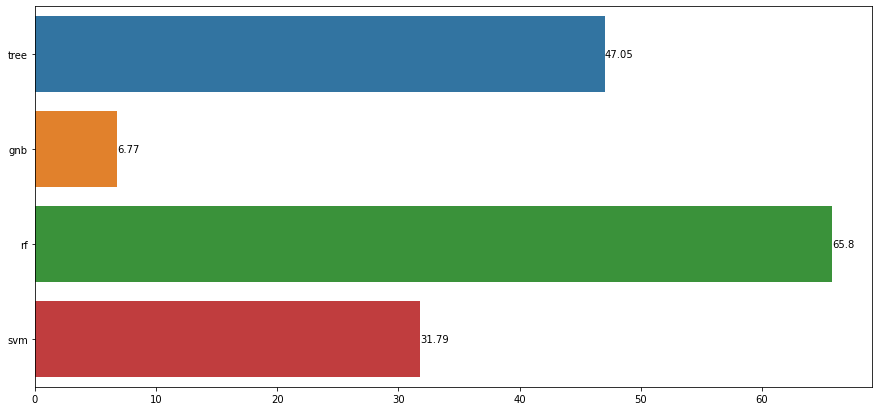

In [231]:
plt.figure(figsize=(15,7))
ax = sns.barplot(score_list,cols)
ax.bar_label(ax.containers[0]);

In [232]:
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [233]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_trains = ohe.fit_transform(y_train)
y_tests = ohe.transform(y_test)

In [234]:
y_trains.shape

(649, 11)

In [235]:
classifier = Sequential()

In [270]:
classifier.add(Dense(units=44,activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Dense(units=22,activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Dense(units=11,activation='sigmoid'))

In [271]:
classifier.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])

In [272]:
epc = 1000
model_run = classifier.fit(X_train,y_trains,epochs=epc,batch_size=10,validation_data=(X_test,y_tests))

Epoch 1/1000
65/65 [==============================] - 4s 18ms/step - loss: 2.2110 - accuracy: 0.3082 - val_loss: 2.0961 - val_accuracy: 0.4663
Epoch 2/1000
65/65 [==============================] - 0s 4ms/step - loss: 1.4275 - accuracy: 0.5331 - val_loss: 1.6736 - val_accuracy: 0.6319
Epoch 3/1000
65/65 [==============================] - 0s 4ms/step - loss: 1.0482 - accuracy: 0.6934 - val_loss: 1.2484 - val_accuracy: 0.8528
Epoch 4/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.9657 - accuracy: 0.7103 - val_loss: 0.9438 - val_accuracy: 0.8650
Epoch 5/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.9310 - accuracy: 0.7180 - val_loss: 0.7079 - val_accuracy: 0.8650
Epoch 6/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.8766 - accuracy: 0.7165 - val_loss: 0.5799 - val_accuracy: 0.9080
Epoch 7/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.8330 - accuracy: 0.7180 - val_loss: 0.4960 - val_accuracy: 0.9080
Epoch

65/65 [==============================] - 0s 4ms/step - loss: 0.5471 - accuracy: 0.8105 - val_loss: 0.3865 - val_accuracy: 0.9325
Epoch 59/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.5650 - accuracy: 0.8074 - val_loss: 0.4234 - val_accuracy: 0.8773
Epoch 60/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4862 - accuracy: 0.8536 - val_loss: 0.4223 - val_accuracy: 0.9018
Epoch 61/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4990 - accuracy: 0.8136 - val_loss: 0.3666 - val_accuracy: 0.9387
Epoch 62/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4717 - accuracy: 0.8166 - val_loss: 0.4341 - val_accuracy: 0.8957
Epoch 63/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.5713 - accuracy: 0.8228 - val_loss: 0.3848 - val_accuracy: 0.9264
Epoch 64/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.5722 - accuracy: 0.8136 - val_loss: 0.4225 - val_accuracy: 0.8589
Epoch 65/1000

65/65 [==============================] - 0s 4ms/step - loss: 0.5124 - accuracy: 0.8043 - val_loss: 0.3866 - val_accuracy: 0.8957
Epoch 116/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.5020 - accuracy: 0.8228 - val_loss: 0.4104 - val_accuracy: 0.9202
Epoch 117/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4425 - accuracy: 0.8398 - val_loss: 0.3491 - val_accuracy: 0.9141
Epoch 118/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.6178 - accuracy: 0.7982 - val_loss: 0.4384 - val_accuracy: 0.8773
Epoch 119/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4792 - accuracy: 0.8552 - val_loss: 0.3801 - val_accuracy: 0.9202
Epoch 120/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4889 - accuracy: 0.8351 - val_loss: 0.3519 - val_accuracy: 0.9018
Epoch 121/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4386 - accuracy: 0.8413 - val_loss: 0.4010 - val_accuracy: 0.8834
Epoch 1

Epoch 172/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.5743 - accuracy: 0.7750 - val_loss: 0.4693 - val_accuracy: 0.8834
Epoch 173/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.5552 - accuracy: 0.8089 - val_loss: 0.5170 - val_accuracy: 0.8834
Epoch 174/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4688 - accuracy: 0.8274 - val_loss: 0.4457 - val_accuracy: 0.8773
Epoch 175/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.5196 - accuracy: 0.8243 - val_loss: 0.4288 - val_accuracy: 0.9018
Epoch 176/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.5120 - accuracy: 0.8151 - val_loss: 0.5058 - val_accuracy: 0.8834
Epoch 177/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.5692 - accuracy: 0.7966 - val_loss: 0.4504 - val_accuracy: 0.8957
Epoch 178/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.5100 - accuracy: 0.8166 - val_loss: 0.4881 - val_accuracy:

Epoch 229/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.5003 - accuracy: 0.8290 - val_loss: 0.3809 - val_accuracy: 0.9202
Epoch 230/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4835 - accuracy: 0.8367 - val_loss: 0.3546 - val_accuracy: 0.9080
Epoch 231/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4864 - accuracy: 0.8490 - val_loss: 0.3946 - val_accuracy: 0.9202
Epoch 232/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.5213 - accuracy: 0.8259 - val_loss: 0.4011 - val_accuracy: 0.9018
Epoch 233/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4595 - accuracy: 0.8274 - val_loss: 0.3797 - val_accuracy: 0.9202
Epoch 234/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4718 - accuracy: 0.8490 - val_loss: 0.4078 - val_accuracy: 0.9325
Epoch 235/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4858 - accuracy: 0.8120 - val_loss: 0.3602 - val_accuracy:

Epoch 286/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4682 - accuracy: 0.8351 - val_loss: 0.4615 - val_accuracy: 0.9141
Epoch 287/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4607 - accuracy: 0.8521 - val_loss: 0.5373 - val_accuracy: 0.8957
Epoch 288/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4530 - accuracy: 0.8336 - val_loss: 0.4153 - val_accuracy: 0.9264
Epoch 289/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4913 - accuracy: 0.8351 - val_loss: 0.3974 - val_accuracy: 0.9202
Epoch 290/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4682 - accuracy: 0.8552 - val_loss: 0.4202 - val_accuracy: 0.9264
Epoch 291/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4471 - accuracy: 0.8398 - val_loss: 0.4508 - val_accuracy: 0.9264
Epoch 292/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4541 - accuracy: 0.8552 - val_loss: 0.4571 - val_accuracy:

Epoch 343/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4251 - accuracy: 0.8243 - val_loss: 0.5720 - val_accuracy: 0.8098
Epoch 344/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4139 - accuracy: 0.8521 - val_loss: 0.5196 - val_accuracy: 0.8896
Epoch 345/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4123 - accuracy: 0.8413 - val_loss: 0.5236 - val_accuracy: 0.9018
Epoch 346/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4598 - accuracy: 0.8505 - val_loss: 0.4995 - val_accuracy: 0.9080
Epoch 347/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4425 - accuracy: 0.8367 - val_loss: 0.4346 - val_accuracy: 0.9141
Epoch 348/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3978 - accuracy: 0.8659 - val_loss: 0.4640 - val_accuracy: 0.9018
Epoch 349/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4392 - accuracy: 0.8582 - val_loss: 0.4837 - val_accuracy:

65/65 [==============================] - 0s 4ms/step - loss: 0.3984 - accuracy: 0.8721 - val_loss: 0.4898 - val_accuracy: 0.8957
Epoch 400/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4212 - accuracy: 0.8475 - val_loss: 0.3882 - val_accuracy: 0.9202
Epoch 401/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4369 - accuracy: 0.8444 - val_loss: 0.4213 - val_accuracy: 0.9264
Epoch 402/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4939 - accuracy: 0.8336 - val_loss: 0.5396 - val_accuracy: 0.8896
Epoch 403/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4601 - accuracy: 0.8351 - val_loss: 0.4610 - val_accuracy: 0.9264
Epoch 404/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4502 - accuracy: 0.8475 - val_loss: 0.4566 - val_accuracy: 0.9202
Epoch 405/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4402 - accuracy: 0.8428 - val_loss: 0.4160 - val_accuracy: 0.9325
Epoch 4

Epoch 456/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4395 - accuracy: 0.8243 - val_loss: 0.4983 - val_accuracy: 0.8834
Epoch 457/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4864 - accuracy: 0.8444 - val_loss: 0.4568 - val_accuracy: 0.8896
Epoch 458/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4178 - accuracy: 0.8505 - val_loss: 0.4628 - val_accuracy: 0.9080
Epoch 459/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.5083 - accuracy: 0.8398 - val_loss: 0.4200 - val_accuracy: 0.9141
Epoch 460/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4472 - accuracy: 0.8413 - val_loss: 0.4633 - val_accuracy: 0.9018
Epoch 461/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4959 - accuracy: 0.8336 - val_loss: 0.4926 - val_accuracy: 0.9141
Epoch 462/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4376 - accuracy: 0.8413 - val_loss: 0.4631 - val_accuracy:

Epoch 513/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4189 - accuracy: 0.8428 - val_loss: 0.4794 - val_accuracy: 0.9080
Epoch 514/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4366 - accuracy: 0.8582 - val_loss: 0.4445 - val_accuracy: 0.9202
Epoch 515/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.3444 - accuracy: 0.8829 - val_loss: 0.4162 - val_accuracy: 0.9325
Epoch 516/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4848 - accuracy: 0.8582 - val_loss: 0.4515 - val_accuracy: 0.9264
Epoch 517/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4123 - accuracy: 0.8536 - val_loss: 0.4609 - val_accuracy: 0.9018
Epoch 518/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.3923 - accuracy: 0.8567 - val_loss: 0.4391 - val_accuracy: 0.9202
Epoch 519/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4519 - accuracy: 0.8444 - val_loss: 0.4835 - val_accuracy:

Epoch 570/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4060 - accuracy: 0.8444 - val_loss: 0.3644 - val_accuracy: 0.9325
Epoch 571/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4568 - accuracy: 0.8613 - val_loss: 0.3700 - val_accuracy: 0.9141
Epoch 572/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4268 - accuracy: 0.8444 - val_loss: 0.3720 - val_accuracy: 0.9202
Epoch 573/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.3388 - accuracy: 0.8767 - val_loss: 0.3661 - val_accuracy: 0.9264
Epoch 574/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4760 - accuracy: 0.8259 - val_loss: 0.3915 - val_accuracy: 0.9202
Epoch 575/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4559 - accuracy: 0.8582 - val_loss: 0.4660 - val_accuracy: 0.9264
Epoch 576/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3926 - accuracy: 0.8582 - val_loss: 0.4175 - val_accuracy:

Epoch 627/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3741 - accuracy: 0.8690 - val_loss: 0.3964 - val_accuracy: 0.9080
Epoch 628/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.3817 - accuracy: 0.8629 - val_loss: 0.4180 - val_accuracy: 0.8712
Epoch 629/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4333 - accuracy: 0.8475 - val_loss: 0.4297 - val_accuracy: 0.8896
Epoch 630/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4854 - accuracy: 0.8305 - val_loss: 0.3973 - val_accuracy: 0.8957
Epoch 631/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.5080 - accuracy: 0.8243 - val_loss: 0.4072 - val_accuracy: 0.8957
Epoch 632/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4770 - accuracy: 0.8444 - val_loss: 0.3643 - val_accuracy: 0.9141
Epoch 633/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4237 - accuracy: 0.8613 - val_loss: 0.3411 - val_accuracy:

Epoch 684/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4005 - accuracy: 0.8505 - val_loss: 0.4323 - val_accuracy: 0.9141
Epoch 685/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3882 - accuracy: 0.8737 - val_loss: 0.4175 - val_accuracy: 0.9141
Epoch 686/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4276 - accuracy: 0.8459 - val_loss: 0.4634 - val_accuracy: 0.8834
Epoch 687/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4187 - accuracy: 0.8536 - val_loss: 0.4404 - val_accuracy: 0.9202
Epoch 688/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4052 - accuracy: 0.8521 - val_loss: 0.3882 - val_accuracy: 0.9325
Epoch 689/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4564 - accuracy: 0.8582 - val_loss: 0.4123 - val_accuracy: 0.9141
Epoch 690/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.4599 - accuracy: 0.8228 - val_loss: 0.4328 - val_accuracy:

Epoch 741/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3996 - accuracy: 0.8505 - val_loss: 0.4265 - val_accuracy: 0.9080
Epoch 742/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4283 - accuracy: 0.8444 - val_loss: 0.4968 - val_accuracy: 0.8650
Epoch 743/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3676 - accuracy: 0.8690 - val_loss: 0.4323 - val_accuracy: 0.8773
Epoch 744/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3976 - accuracy: 0.8644 - val_loss: 0.3876 - val_accuracy: 0.9202
Epoch 745/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4008 - accuracy: 0.8567 - val_loss: 0.3811 - val_accuracy: 0.9202
Epoch 746/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3907 - accuracy: 0.8536 - val_loss: 0.3986 - val_accuracy: 0.9202
Epoch 747/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3574 - accuracy: 0.8706 - val_loss: 0.3373 - val_accuracy:

Epoch 798/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4176 - accuracy: 0.8644 - val_loss: 0.3868 - val_accuracy: 0.9141
Epoch 799/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4731 - accuracy: 0.8536 - val_loss: 0.3520 - val_accuracy: 0.9141
Epoch 800/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3864 - accuracy: 0.8752 - val_loss: 0.4211 - val_accuracy: 0.9202
Epoch 801/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3934 - accuracy: 0.8444 - val_loss: 0.4293 - val_accuracy: 0.9018
Epoch 802/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3565 - accuracy: 0.8814 - val_loss: 0.3621 - val_accuracy: 0.9264
Epoch 803/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4522 - accuracy: 0.8475 - val_loss: 0.4060 - val_accuracy: 0.8896
Epoch 804/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3563 - accuracy: 0.8706 - val_loss: 0.3525 - val_accuracy:

Epoch 855/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3654 - accuracy: 0.8659 - val_loss: 0.4325 - val_accuracy: 0.9264
Epoch 856/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4214 - accuracy: 0.8567 - val_loss: 0.4128 - val_accuracy: 0.9080
Epoch 857/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3961 - accuracy: 0.8767 - val_loss: 0.3668 - val_accuracy: 0.9264
Epoch 858/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4689 - accuracy: 0.8336 - val_loss: 0.3860 - val_accuracy: 0.9202
Epoch 859/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4126 - accuracy: 0.8598 - val_loss: 0.4207 - val_accuracy: 0.9018
Epoch 860/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4021 - accuracy: 0.8552 - val_loss: 0.4028 - val_accuracy: 0.9141
Epoch 861/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4434 - accuracy: 0.8505 - val_loss: 0.4108 - val_accuracy:

65/65 [==============================] - 0s 4ms/step - loss: 0.4452 - accuracy: 0.8613 - val_loss: 0.2996 - val_accuracy: 0.9325
Epoch 912/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4123 - accuracy: 0.8536 - val_loss: 0.3500 - val_accuracy: 0.9202
Epoch 913/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3821 - accuracy: 0.8598 - val_loss: 0.3090 - val_accuracy: 0.9264
Epoch 914/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3204 - accuracy: 0.8937 - val_loss: 0.3467 - val_accuracy: 0.9141
Epoch 915/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4208 - accuracy: 0.8536 - val_loss: 0.3791 - val_accuracy: 0.9202
Epoch 916/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3318 - accuracy: 0.8983 - val_loss: 0.3058 - val_accuracy: 0.9325
Epoch 917/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3794 - accuracy: 0.8613 - val_loss: 0.3139 - val_accuracy: 0.9264
Epoch 9

Epoch 968/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3677 - accuracy: 0.8814 - val_loss: 0.3897 - val_accuracy: 0.9264
Epoch 969/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.3899 - accuracy: 0.8737 - val_loss: 0.4154 - val_accuracy: 0.8957
Epoch 970/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3534 - accuracy: 0.8783 - val_loss: 0.3575 - val_accuracy: 0.9264
Epoch 971/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.3752 - accuracy: 0.8675 - val_loss: 0.3867 - val_accuracy: 0.9264
Epoch 972/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4179 - accuracy: 0.8398 - val_loss: 0.4138 - val_accuracy: 0.9018
Epoch 973/1000
65/65 [==============================] - 0s 4ms/step - loss: 0.4618 - accuracy: 0.8367 - val_loss: 0.4155 - val_accuracy: 0.8834
Epoch 974/1000
65/65 [==============================] - 0s 6ms/step - loss: 0.4537 - accuracy: 0.8290 - val_loss: 0.4684 - val_accuracy:

C:\Users\91700\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\91700\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Loss')

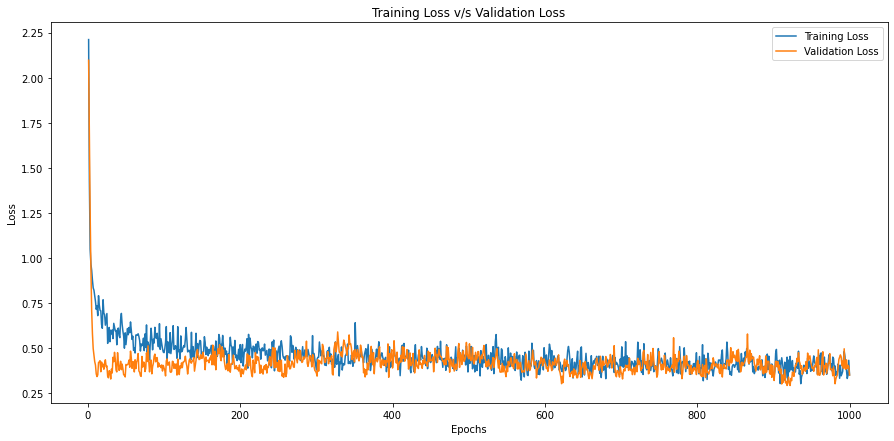

In [273]:
plt.figure(figsize=(15,7))
epochs = range(1,epc+1)
train_loss = model_run.history['loss']
validation_loss = model_run.history['val_loss']
sns.lineplot(epochs,train_loss, label='Training Loss')
sns.lineplot(epochs,validation_loss, label='Validation Loss')
plt.title('Training Loss v/s Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

C:\Users\91700\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\91700\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Accuracy')

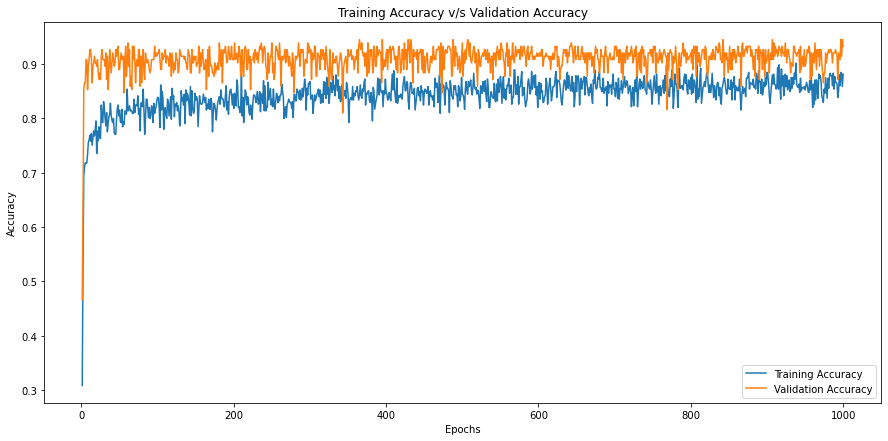

In [274]:
plt.figure(figsize=(15,7))
epochs = range(1,epc+1)
train_accuracy = model_run.history['accuracy']
validation_accuracy = model_run.history['val_accuracy']
sns.lineplot(epochs,train_accuracy, label='Training Accuracy')
sns.lineplot(epochs,validation_accuracy, label='Validation Accuracy')
plt.title('Training Accuracy v/s Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [275]:
results = classifier.evaluate(X_test,y_tests)[1]

6/6 [==============================] - 0s 2ms/step - loss: 0.3492 - accuracy: 0.9325


In [276]:
results

0.9325153231620789

In [277]:
y_pred = classifier.predict(X_test)
y_pred.shape

(163, 11)

In [278]:

for i in range(y_pred.shape[0]):
    lit = list(y_pred[i])
    val = max(lit)
    ind = lit.index(val)
    for j in range(len(y_pred[i])):
        if j==ind:
            y_pred[i][j]=1
        else:
            y_pred[i][j]=0.0

In [279]:
y_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [280]:
print(classification_report(y_tests,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.95      0.98        22
           2       0.93      1.00      0.97        14
           3       0.50      0.33      0.40         3
           4       0.83      0.88      0.86        17
           5       0.00      0.00      0.00         1
           6       0.87      1.00      0.93        13
           7       0.96      0.96      0.96        26
           8       1.00      0.67      0.80         3
           9       0.89      1.00      0.94        16
          10       1.00      0.88      0.93        24

   micro avg       0.93      0.93      0.93       163
   macro avg       0.81      0.79      0.79       163
weighted avg       0.93      0.93      0.93       163
 samples avg       0.93      0.93      0.93       163



C:\Users\91700\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [281]:
classifier.save('model')

INFO:tensorflow:Assets written to: model\assets
